# Exploratory Data Analysis in SQL and Python

Analyzing the San-Francisco Crime dataset Using SQL and Python for indepth analysis.<br>
We connect to MySQL server and workbench and make analysis with the crime_data database.

In [11]:
# we import some required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import time
print('Done!')

Done!


In [2]:
import mysql
from mysql.connector import Error
from getpass import getpass

db_name = 'crime_data'
try:
    connection = mysql.connector.connect(host='localhost',
                                         database=db_name,
                                         user=input('Enter UserName:'),
                                         password=getpass('Enter Password:'))
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version ", db_Info)
        cursor = connection.cursor()
        cursor.execute("select database();")
        record = cursor.fetchone()
        print("You're connected to database: ", record)

except Error as e:
    print("Error while connecting to MySQL", e)

Enter UserName:danam
Enter Password:········
Connected to MySQL Server version  8.0.24
You're connected to database:  ('crime_data',)


In [9]:
def query_to_df(query):
    st = time.time()
    # Assert Every Query ends with a semi-colon
    try:
        assert query.endswith(';')
    except AssertionError:
        return 'ERROR: Query Must End with ;'

    # so we never have more than 50 rows displayed
    pd.set_option('display.max_rows', 50) 
    df = None

    # Process the query
    cursor.execute(query)
    columns = cursor.description
    result = []
    for value in cursor.fetchall():
        tmp = {}
        for (index,column) in enumerate(value):
            tmp[columns[index][0]] = [column]
        result.append(tmp)

    # Create a DataFrame from all results
    for ind, data in enumerate(result):
        if ind >= 1:
            x = pd.DataFrame(data)
            df = pd.concat([df, x], ignore_index=True)
        else:
            df = pd.DataFrame(data)
    print(f'Query ran for {time.time()-st} secs!')
    return df

In [4]:
# Let's see the tables in crime_data database

query_to_df(
'SHOW TABLES;'
)

Query ran for 0.004985809326171875 secs!


,Tables_in_crime_data
0,sf_crime_data


In [12]:
# For the sf_crime_data

query = 'SELECT * FROM sf_crime_data LIMIT 3;'
query_to_df(query)

Query ran for 0.017951488494873047 secs!


,id,incidnt_num,category,descript,day_of_week,dates,times,pd_district,resolution,address,lon,lat,location
0,1,140000000,VEHICLE THEFT,STOLEN AND RECOVERED VEHICLE,Friday,01/31/2014 08:00:00 AM +0000,0 days 17:00:00,INGLESIDE,NONE,0 Block of GARRISON AV,-122.413628,37.709724,"(37.709725805163, -122.413623946206)"
1,2,140000000,ASSAULT,BATTERY,Friday,01/31/2014 08:00:00 AM +0000,0 days 17:45:00,TARAVAL,"ARREST, CITED",100 Block of FONT BL,-122.473709,37.715488,"(37.7154876086057, -122.47370623066)"
2,3,140000000,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,Friday,01/31/2014 08:00:00 AM +0000,0 days 15:30:00,PARK,NONE,0 Block of CASTRO ST,-122.435722,37.768688,"(37.7686887134351, -122.435718550322)"


Let's see how many crimes have been reported

In [13]:
query_to_df(
"SELECT COUNT(*) total_crimes FROM sf_crime_data;"
)

Query ran for 0.009974479675292969 secs!


,total_crimes
0,30400


In [14]:
query_to_df(
"SELECT DISTINCT category FROM sf_crime_data;"
)

Query ran for 0.0468752384185791 secs!


,category
0,VEHICLE THEFT
1,ASSAULT
2,SUSPICIOUS OCC
3,OTHER OFFENSES
4,DRUG/NARCOTIC
5,LARCENY/THEFT
6,NON-CRIMINAL
7,DRUNKENNESS
8,WARRANTS
9,ROBBERY


Let's see what types of crimes occur generally, from most to least frequent

In [16]:
query_to_df(
"SELECT DISTINCT category, COUNT(*) num_crimes FROM sf_crime_data GROUP BY 1 ORDER BY 2 DESC;"
)

Query ran for 0.057770729064941406 secs!


,category,num_crimes
0,LARCENY/THEFT,8211
1,OTHER OFFENSES,3719
2,NON-CRIMINAL,3554
3,ASSAULT,2399
4,VANDALISM,1545
5,BURGLARY,1541
6,WARRANTS,1539
7,VEHICLE THEFT,1468
8,DRUG/NARCOTIC,1452
9,MISSING PERSON,1003


Let's zoom in on the Top 10 categories of offences 

Query ran for 0.0418550968170166 secs!


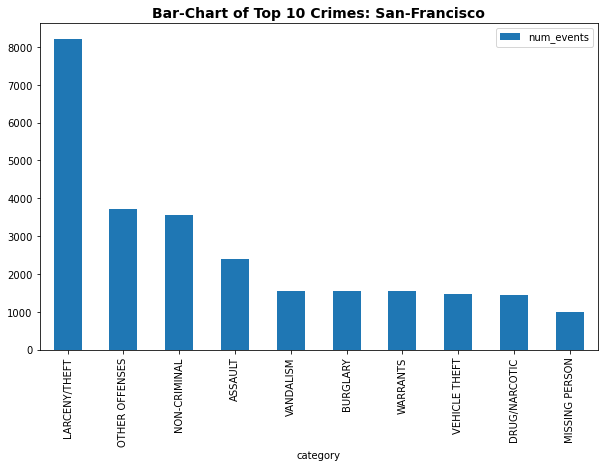

In [32]:
(query_to_df(
"SELECT category, COUNT(*) num_events FROM sf_crime_data GROUP BY 1 ORDER BY 2 DESC LIMIT 10;"
)).set_index('category').plot.bar(figsize=(10,6))
plt.title('Bar-Chart of Top 10 Crimes: San-Francisco', fontweight='bold', fontsize=14)
plt.show()